In [ ]:
!pip install geopy > delete.txt
!pip  install datasets > delete.txt
!pip install torch torchvision datasets > delete.txt
!pip install huggingface_hub > delete.txt
!rm delete.txt

In [ ]:
!git config --global credential.helper store


In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
from huggingface_hub import whoami

user = whoami()
print(f"Logged in as {user['name']}")

In [ ]:
from datasets import load_dataset, Image

dataset_train = load_dataset("cis-5190-final-fall24/eng_photos", split="train")
dataset_test = load_dataset("cis-5190-final-fall24/eng_photos", split="test")

README.md:   0%|          | 0.00/474 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

train-00000-of-00024.parquet:   0%|          | 0.00/675M [00:00<?, ?B/s]

train-00001-of-00024.parquet:   0%|          | 0.00/760M [00:00<?, ?B/s]

train-00002-of-00024.parquet:   0%|          | 0.00/690M [00:00<?, ?B/s]

train-00003-of-00024.parquet:   0%|          | 0.00/569M [00:00<?, ?B/s]

train-00004-of-00024.parquet:   0%|          | 0.00/642M [00:00<?, ?B/s]

train-00005-of-00024.parquet:   0%|          | 0.00/593M [00:00<?, ?B/s]

train-00006-of-00024.parquet:   0%|          | 0.00/566M [00:00<?, ?B/s]

train-00007-of-00024.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00008-of-00024.parquet:   0%|          | 0.00/159M [00:00<?, ?B/s]

train-00009-of-00024.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

train-00010-of-00024.parquet:   0%|          | 0.00/173M [00:00<?, ?B/s]

train-00011-of-00024.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

train-00012-of-00024.parquet:   0%|          | 0.00/159M [00:00<?, ?B/s]

train-00013-of-00024.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

train-00014-of-00024.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

train-00015-of-00024.parquet:   0%|          | 0.00/153M [00:00<?, ?B/s]

train-00016-of-00024.parquet:   0%|          | 0.00/333M [00:00<?, ?B/s]

train-00017-of-00024.parquet:   0%|          | 0.00/647M [00:00<?, ?B/s]

train-00018-of-00024.parquet:   0%|          | 0.00/557M [00:00<?, ?B/s]

train-00019-of-00024.parquet:   0%|          | 0.00/596M [00:00<?, ?B/s]

train-00020-of-00024.parquet:   0%|          | 0.00/656M [00:00<?, ?B/s]

train-00021-of-00024.parquet:   0%|          | 0.00/640M [00:00<?, ?B/s]

train-00022-of-00024.parquet:   0%|          | 0.00/585M [00:00<?, ?B/s]

train-00023-of-00024.parquet:   0%|          | 0.00/543M [00:00<?, ?B/s]

test-00000-of-00004.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

test-00001-of-00004.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

test-00002-of-00004.parquet:   0%|          | 0.00/379M [00:00<?, ?B/s]

test-00003-of-00004.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2303 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/301 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['image', 'Latitude', 'Longitude'],
    num_rows: 2303
})
Dataset({
    features: ['image', 'Latitude', 'Longitude'],
    num_rows: 301
})


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from geopy.distance import geodesic
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


# Dataset Class
class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.latitude_mean = lat_mean or np.mean(np.array(self.hf_dataset['Latitude']))
        self.latitude_std = lat_std or np.std(np.array(self.hf_dataset['Latitude']))
        self.longitude_mean = lon_mean or np.mean(np.array(self.hf_dataset['Longitude']))
        self.longitude_std = lon_std or np.std(np.array(self.hf_dataset['Longitude']))

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        example = self.hf_dataset[idx]
        image = example['image']
        latitude = example['Latitude']
        longitude = example['Longitude']
        if self.transform:
            image = self.transform(image)
        latitude = (latitude - self.latitude_mean) / self.latitude_std
        longitude = (longitude - self.longitude_mean) / self.longitude_std
        gps_coords = torch.tensor([latitude, longitude], dtype=torch.float32)
        return image, gps_coords

# Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders
train_dataset = GPSImageDataset(hf_dataset=dataset_train, transform=transform_train)
val_dataset = GPSImageDataset(hf_dataset=dataset_test, transform=transform_val,
                               lat_mean=train_dataset.latitude_mean,
                               lat_std=train_dataset.latitude_std,
                               lon_mean=train_dataset.longitude_mean,
                               lon_std=train_dataset.longitude_std)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

print(f"Latitude Mean: {lat_mean}, Latitude Std: {lat_std}")
print(f"Longitude Mean: {lon_mean}, Longitude Std: {lon_std}")

# Model Definition
class ResNetGPSModel(nn.Module):
    def __init__(self):
        super(ResNetGPSModel, self).__init__()
        self.resnet = models.resnet101(weights="IMAGENET1K_V1")  # Updated for PyTorch >=0.13
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.4),  # Dropout for regularization
            nn.Linear(self.resnet.fc.in_features, 2)  # Latitude and Longitude
        )

    def forward(self, x):
        return self.resnet(x)

# Loss Function (MSE + Geodesic)
def custom_loss(pred, target, lat_mean, lat_std, lon_mean, lon_std):
    mse_loss = nn.MSELoss()(pred, target)
    pred = pred * torch.tensor([lat_std, lon_std]).to(pred.device) + torch.tensor([lat_mean, lon_mean]).to(pred.device)
    target = target * torch.tensor([lat_std, lon_std]).to(target.device) + torch.tensor([lat_mean, lon_mean]).to(target.device)
    geodesic_errors = torch.tensor([geodesic((p[0].item(), p[1].item()), (t[0].item(), t[1].item())).meters for p, t in zip(pred, target)])
    geodesic_loss = torch.mean(geodesic_errors)
    return mse_loss + 0.1 * geodesic_loss  # Weighted combination of MSE and geodesic distance

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetGPSModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=20)

scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
num_epochs = 20
best_val_loss = float('inf')

In [ ]:


# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, gps_coords in train_loader:
        images, gps_coords = images.to(device), gps_coords.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision
            outputs = model(images)
            loss = custom_loss(outputs, gps_coords,
                               train_dataset.latitude_mean, train_dataset.latitude_std,
                               train_dataset.longitude_mean, train_dataset.longitude_std)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, gps_coords in val_loader:
            images, gps_coords = images.to(device), gps_coords.to(device)
            outputs = model(images)
            loss = custom_loss(outputs, gps_coords,
                               train_dataset.latitude_mean, train_dataset.latitude_std,
                               train_dataset.longitude_mean, train_dataset.longitude_std)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")


Mean Geodesic Distance Error (meters): 57.38


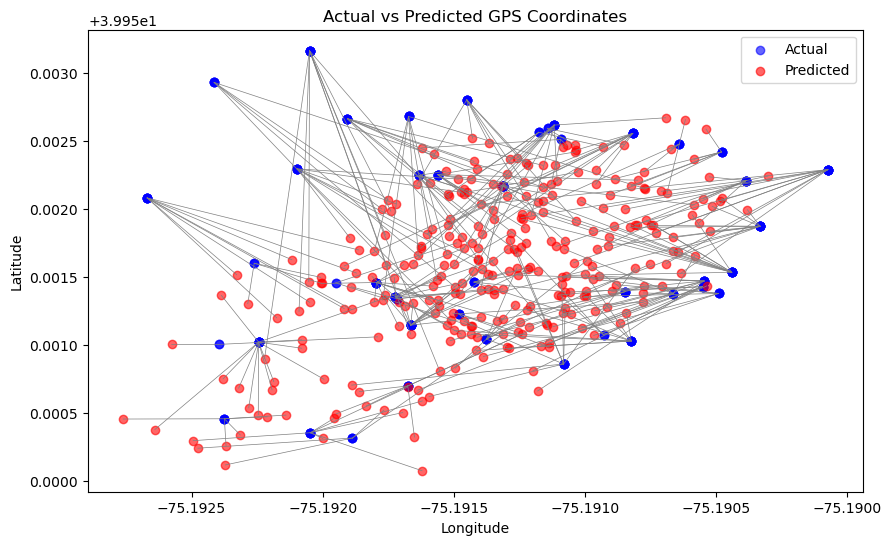

In [ ]:

# Load the Best Model
model.load_state_dict(torch.load("best_model.pth"))

# Evaluation
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for images, gps_coords in val_loader:
        images, gps_coords = images.to(device), gps_coords.to(device)
        outputs = model(images)
        preds.append(outputs.cpu())
        actuals.append(gps_coords.cpu())
preds = torch.cat(preds).numpy()
actuals = torch.cat(actuals).numpy()

# Denormalize and Calculate Geodesic Distance
preds_denorm = preds * np.array([train_dataset.latitude_std, train_dataset.longitude_std]) + \
               np.array([train_dataset.latitude_mean, train_dataset.longitude_mean])
actuals_denorm = actuals * np.array([train_dataset.latitude_std, train_dataset.longitude_std]) + \
                 np.array([train_dataset.latitude_mean, train_dataset.longitude_mean])

geodesic_errors = [
    geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
    for actual, pred in zip(actuals_denorm, preds_denorm)
]
mean_geodesic_error = np.mean(geodesic_errors)
print(f"Mean Geodesic Distance Error (meters): {mean_geodesic_error:.2f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(actuals_denorm[:, 1], actuals_denorm[:, 0], color='blue', label='Actual', alpha=0.6)
plt.scatter(preds_denorm[:, 1], preds_denorm[:, 0], color='red', label='Predicted', alpha=0.6)
for i in range(len(actuals_denorm)):
    plt.plot([actuals_denorm[i, 1], preds_denorm[i, 1]], [actuals_denorm[i, 0], preds_denorm[i, 0]], color='gray', linewidth=0.5)
plt.legend()
plt.title("Actual vs Predicted GPS Coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
print(1)

1
